In [19]:
import os
from tensorflow import keras
import numpy as np
import tensorflow as tf
import keras.layers as layers
from sklearn.model_selection import train_test_split

In [20]:
print(tf.version.VERSION)

2.11.0


In [21]:
tf.keras.datasets.fashion_mnist.load_data()
train, test = tf.keras.datasets.fashion_mnist.load_data()

# wydobycie obrazów oraz labelek
images, labels = train

# normalizacja wartości pikseli (maks. wartość wynosi 255.0, 
# czyli aby znormalizować nasze dane, musimy podzielić każdy piksel przez maks. wartość)
images = images/255.0

# zapisujemy dane jako int
labels = labels.astype(np.int32)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=10, stratify=labels)

In [23]:
# stworzenie zbioru typu Dataset z naszej listy
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# ustawienie batch_size na 32 oraz przetasowanie na bazie 1000 próbek
train_ds = train_ds.shuffle(1000).batch(32)

In [24]:
# Define a simple sequential model
def create_model():
    #stworzenie modelu
    f_mnist_model = tf.keras.Sequential([
        # spłaszczanie obrazka do wektora jednowymiarowego
        layers.Flatten(input_shape=[28, 28]),

        layers.Dense(300, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(150, activation='relu'),
        layers.Dense(100, activation='relu'),
        
        # ostatnia warstwa posiada tyle neuronów ile mamy klas
        layers.Dense(10, activation='softmax')])
    
    f_mnist_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

    return f_mnist_model

In [25]:
# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 300)               235500    
                                                                 
 dense_16 (Dense)            (None, 200)               60200     
                                                                 
 dense_17 (Dense)            (None, 150)               30150     
                                                                 
 dense_18 (Dense)            (None, 100)               15100     
                                                                 
 dense_19 (Dense)            (None, 10)                1010      
                                                                 
Total params: 341,960
Trainable params: 341,960
Non-tr

### Zapis punktów kontrolnych podczas treningu

In [26]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [27]:
train_stats = model.fit(train_ds, epochs=10, validation_data=(X_test, y_test), verbose=1, 
                        callbacks=[cp_callback])

Epoch 1/10
1681/1688 [============================>.] - ETA: 0s - loss: 0.4980 - accuracy: 0.8196
Epoch 1: saving model to training_1\cp.ckpt
1688/1688 [==============================] - 11s 6ms/step - loss: 0.4976 - accuracy: 0.8198 - val_loss: 0.4410 - val_accuracy: 0.8442
Epoch 2/10
1685/1688 [============================>.] - ETA: 0s - loss: 0.3787 - accuracy: 0.8617
Epoch 2: saving model to training_1\cp.ckpt
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3789 - accuracy: 0.8617 - val_loss: 0.3708 - val_accuracy: 0.8648
Epoch 3/10
1684/1688 [============================>.] - ETA: 0s - loss: 0.3425 - accuracy: 0.8730
Epoch 3: saving model to training_1\cp.ckpt
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3424 - accuracy: 0.8731 - val_loss: 0.3425 - val_accuracy: 0.8730
Epoch 4/10
1686/1688 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.8824
Epoch 4: saving model to training_1\cp.ckpt
1688/1688 [=====================

In [28]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

#### Nowy, niewytrenowany model i ocena go na zestawie testowym. Niewyszkolony model będzie działał na poziomach przypadkowych

In [29]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

188/188 - 1s - loss: 2.3299 - accuracy: 0.0808 - 585ms/epoch - 3ms/step
Untrained model, accuracy:  8.08%


#### Załadowanie ciężarów z punktu kontrolnego i ponowna ocena

In [30]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

188/188 - 0s - loss: 0.3258 - accuracy: 0.8862 - 385ms/epoch - 2ms/step
Restored model, accuracy: 88.62%


### Nowy model i zapisywanie unikatowo nazwanych punktów kontrolnych raz na pięć epok

In [31]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_ds,
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(X_test, y_test),
          verbose=0)


Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 1: saving model to training_2\cp-0001.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt

Epoch 2: saving model to training_2\cp-0002.ckpt


In [35]:
os.listdir(checkpoint_dir)

['checkpoint',
 'cp-0000.ckpt.data-00000-of-00001',
 'cp-0000.ckpt.index',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.index',
 'cp-0007.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0009.ckpt.data-00000-of-00001',
 'cp-0009.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index',
 'cp-0011.ckpt.data-00000-of-00001',
 'cp-0011.ckpt.index',
 'cp-0012.ckpt.data-00000-of-00001',
 'cp-0012.ckpt.index',
 'cp-0013.ckpt.data-00000-of-00001',
 'cp-0013.ckpt.index',
 'cp-0014.ckpt.data-00000-of-00001',
 'cp-0014.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00001',
 'cp-0015.ckpt.index',
 'cp-0016.ckpt.data-00000

In [36]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2\\cp-0050.ckpt'

#### Aby przetestować, zresetujemy model i załadujemy najnowszy punkt kontrolny

In [37]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

188/188 - 1s - loss: 0.5488 - accuracy: 0.8928 - 605ms/epoch - 3ms/step
Restored model, accuracy: 89.28%


### Zapisywanie całego modelu

In [38]:
# Create and train a new model instance.
model = create_model()
model.fit(train_ds, epochs=5)

# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

Epoch 1/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.5024 - accuracy: 0.8159
Epoch 2/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3760 - accuracy: 0.8613
Epoch 3/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3357 - accuracy: 0.8777
Epoch 4/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3109 - accuracy: 0.8857
Epoch 5/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.2953 - accuracy: 0.8904


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


#### Przeładowujemy nowy model Keras z zapisanego modelu

In [40]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_35 (Dense)            (None, 300)               235500    
                                                                 
 dense_36 (Dense)            (None, 200)               60200     
                                                                 
 dense_37 (Dense)            (None, 150)               30150     
                                                                 
 dense_38 (Dense)            (None, 100)               15100     
                                                                 
 dense_39 (Dense)            (None, 10)                1010      
                                                                 
Total params: 341,960
Trainable params: 341,960
Non-tr

### Próba przeprowadzenia oceny i prognozy z załadowanym modelem

In [41]:
# Evaluate the restored model
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(X_test).shape)

188/188 - 1s - loss: 0.3325 - accuracy: 0.8730 - 513ms/epoch - 3ms/step
Restored model, accuracy: 87.30%
188/188 [==============================] - 1s 2ms/step
(6000, 10)


In [42]:
y_pred = model.predict(X_test)
print("probs : ", y_pred[2])
print("klasa :", np.argmax(y_pred[2]))
print("rzeczywista klasa: ", y_test[2])

188/188 [==============================] - 0s 2ms/step
probs :  [8.8168832e-08 3.3006856e-08 8.1174910e-08 9.2237080e-08 9.3882264e-08
 8.8617811e-03 1.4648687e-08 9.9001795e-01 1.7787712e-05 1.1021026e-03]
klasa : 7
rzeczywista klasa:  7


'\nprobs :  [4.0548810e-15 1.0000000e+00 9.3477974e-17 5.3090128e-13 7.5702587e-15\n 5.9295928e-25 2.1536054e-11 3.4459677e-24 2.8725664e-16 2.4974258e-22]\nklasa : 1\nrzeczywista klasa:  1\n'

In [53]:
import albumentations as A
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate)

In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [55]:
tfds.__version__

'4.8.2'

In [110]:
tf.keras.datasets.fashion_mnist.load_data()
data, info = tfds.load(name='fashion_mnist', split="train", as_supervised=True, with_info=True)
data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\magda\tensorflow_datasets\fashion_mnist\3.0.1.incompleteZSM3KI\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\magda\tensorflow_datasets\fashion_mnist\3.0.1.incompleteZSM3KI\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\magda\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [111]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\magda\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
  

### An Example Pipeline Using tf.image

#### Process Data

In [113]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

ds_tf = data.map(partial(process_image, img_size=28), num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_tf

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### View images from the dataset

In [114]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

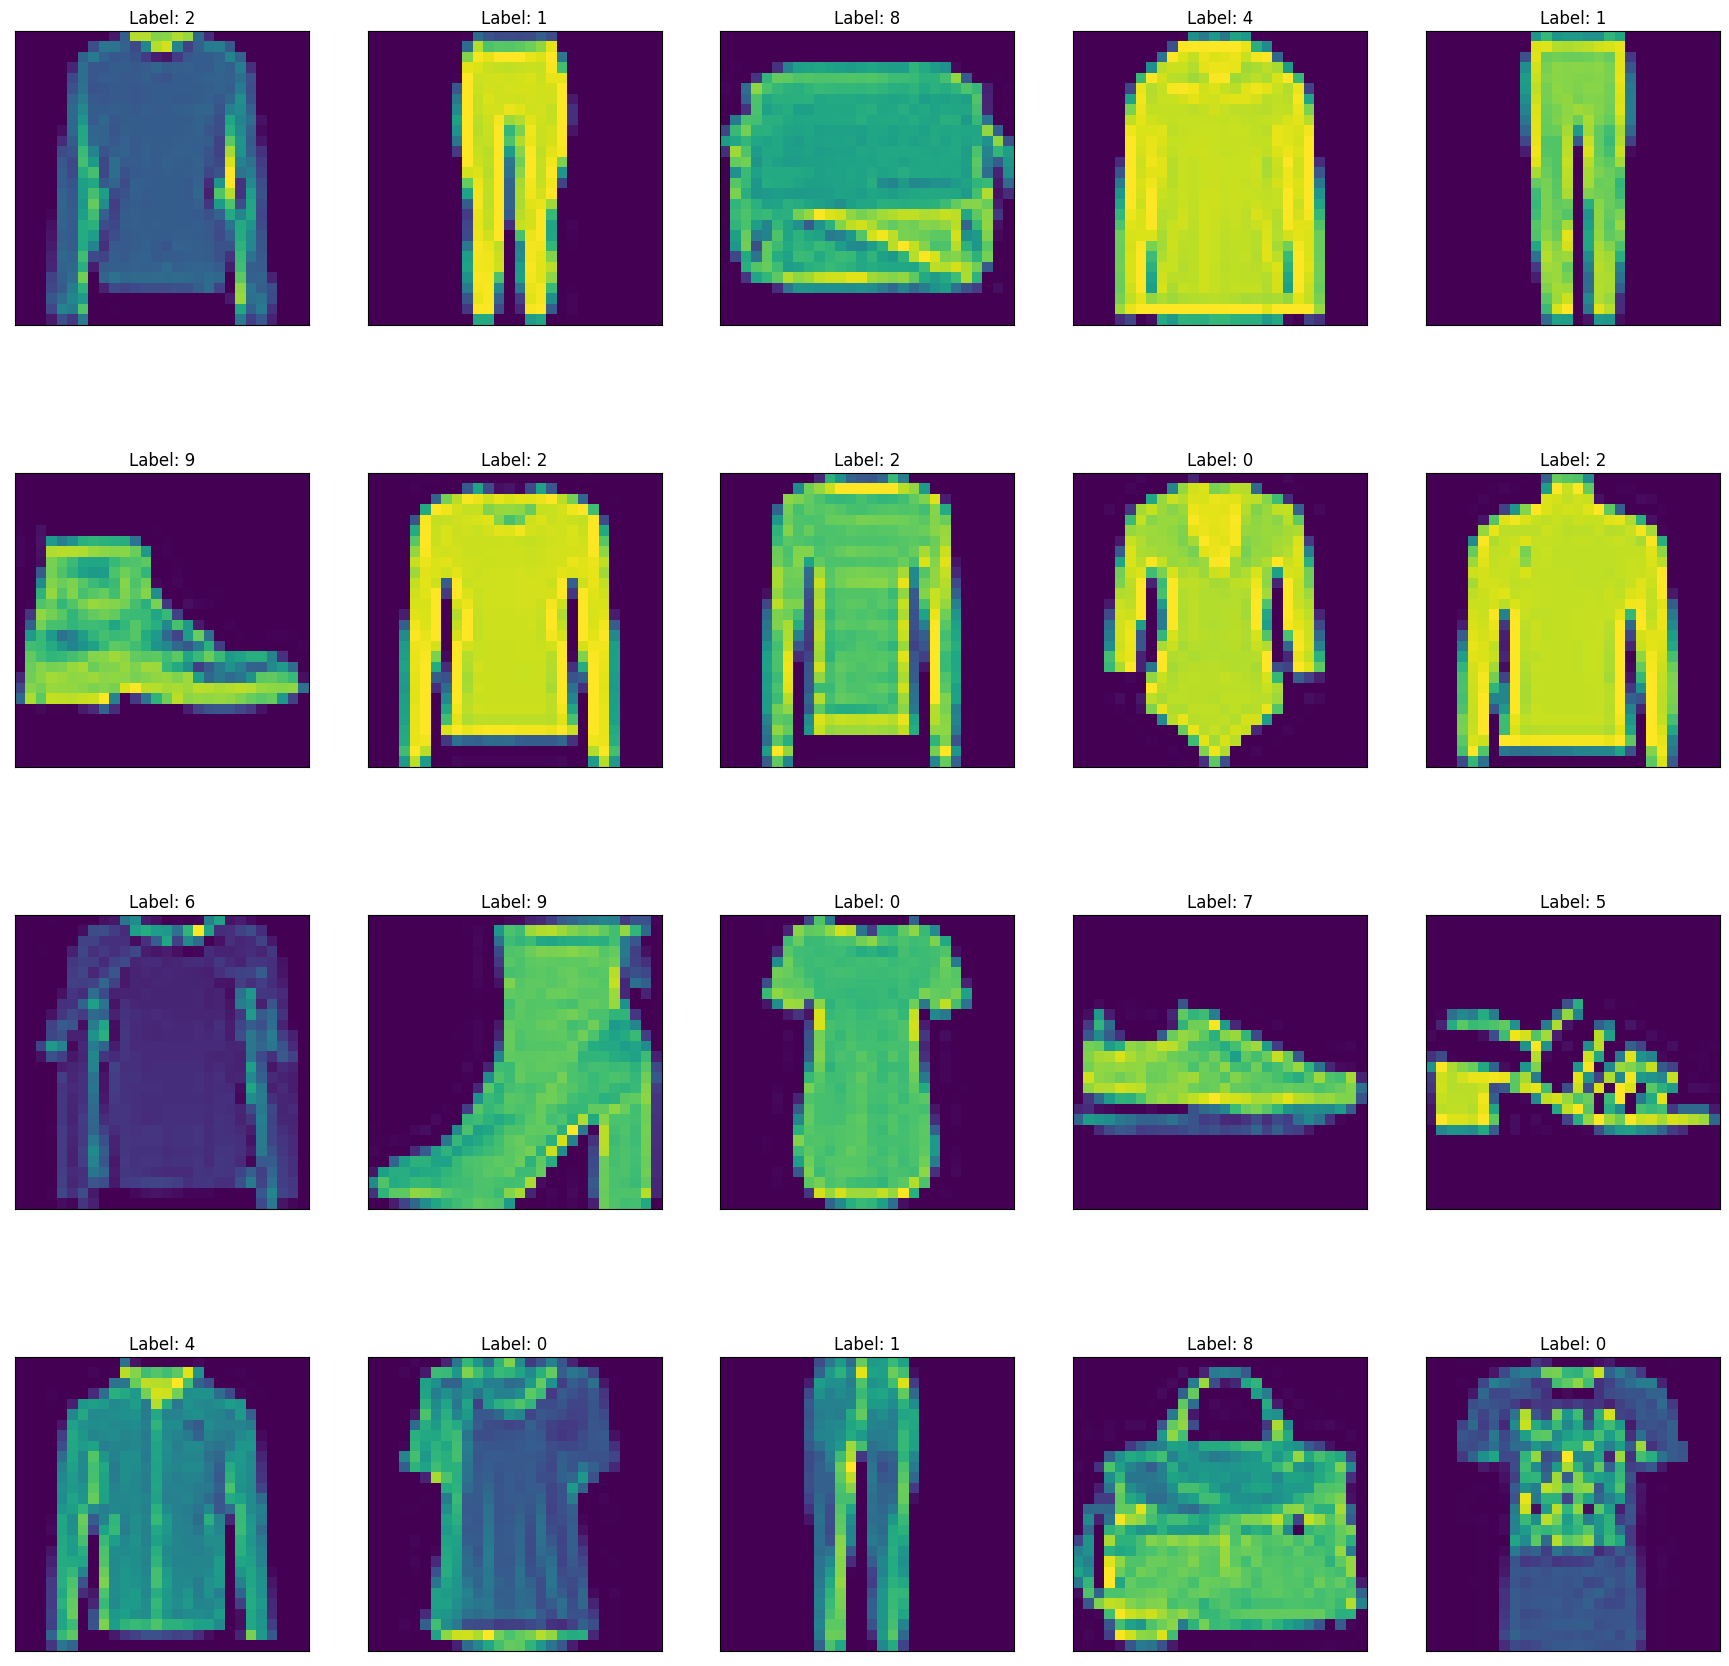

In [115]:
view_image(ds_tf)

In [150]:
n_model = create_model()
n_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_50 (Dense)            (None, 300)               235500    
                                                                 
 dense_51 (Dense)            (None, 200)               60200     
                                                                 
 dense_52 (Dense)            (None, 150)               30150     
                                                                 
 dense_53 (Dense)            (None, 100)               15100     
                                                                 
 dense_54 (Dense)            (None, 10)                1010      
                                                                 
Total params: 341,960
Trainable params: 341,960
Non-t

In [151]:
n_model.fit(ds_tf, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5141 - accuracy: 0.8119
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3878 - accuracy: 0.8581
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3516 - accuracy: 0.8700
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3310 - accuracy: 0.8773
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3132 - accuracy: 0.8832
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2993 - accuracy: 0.8892
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2857 - accuracy: 0.8929
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2749 - accuracy: 0.8958
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2658 - accuracy: 0.9005
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2

### An Example Pipeline using albumentations

#### Create Pipeline to Process data

In [116]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, 
                               val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [117]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [122]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [123]:
# create dataset
ds_alb = data.map(partial(process_data, img_size=28),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

#### Restoring dataset shapes

In [124]:
def set_shapes(img, label, img_shape=(28,28,1)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

In [125]:
ds_alb = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### View images from the dataset

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\augmentations\functional.py:155: UserWarning: HueSaturationValue: hue_shift and sat_shift are not applicable to grayscale image. Set them to 0 or use RGB image
  warn(


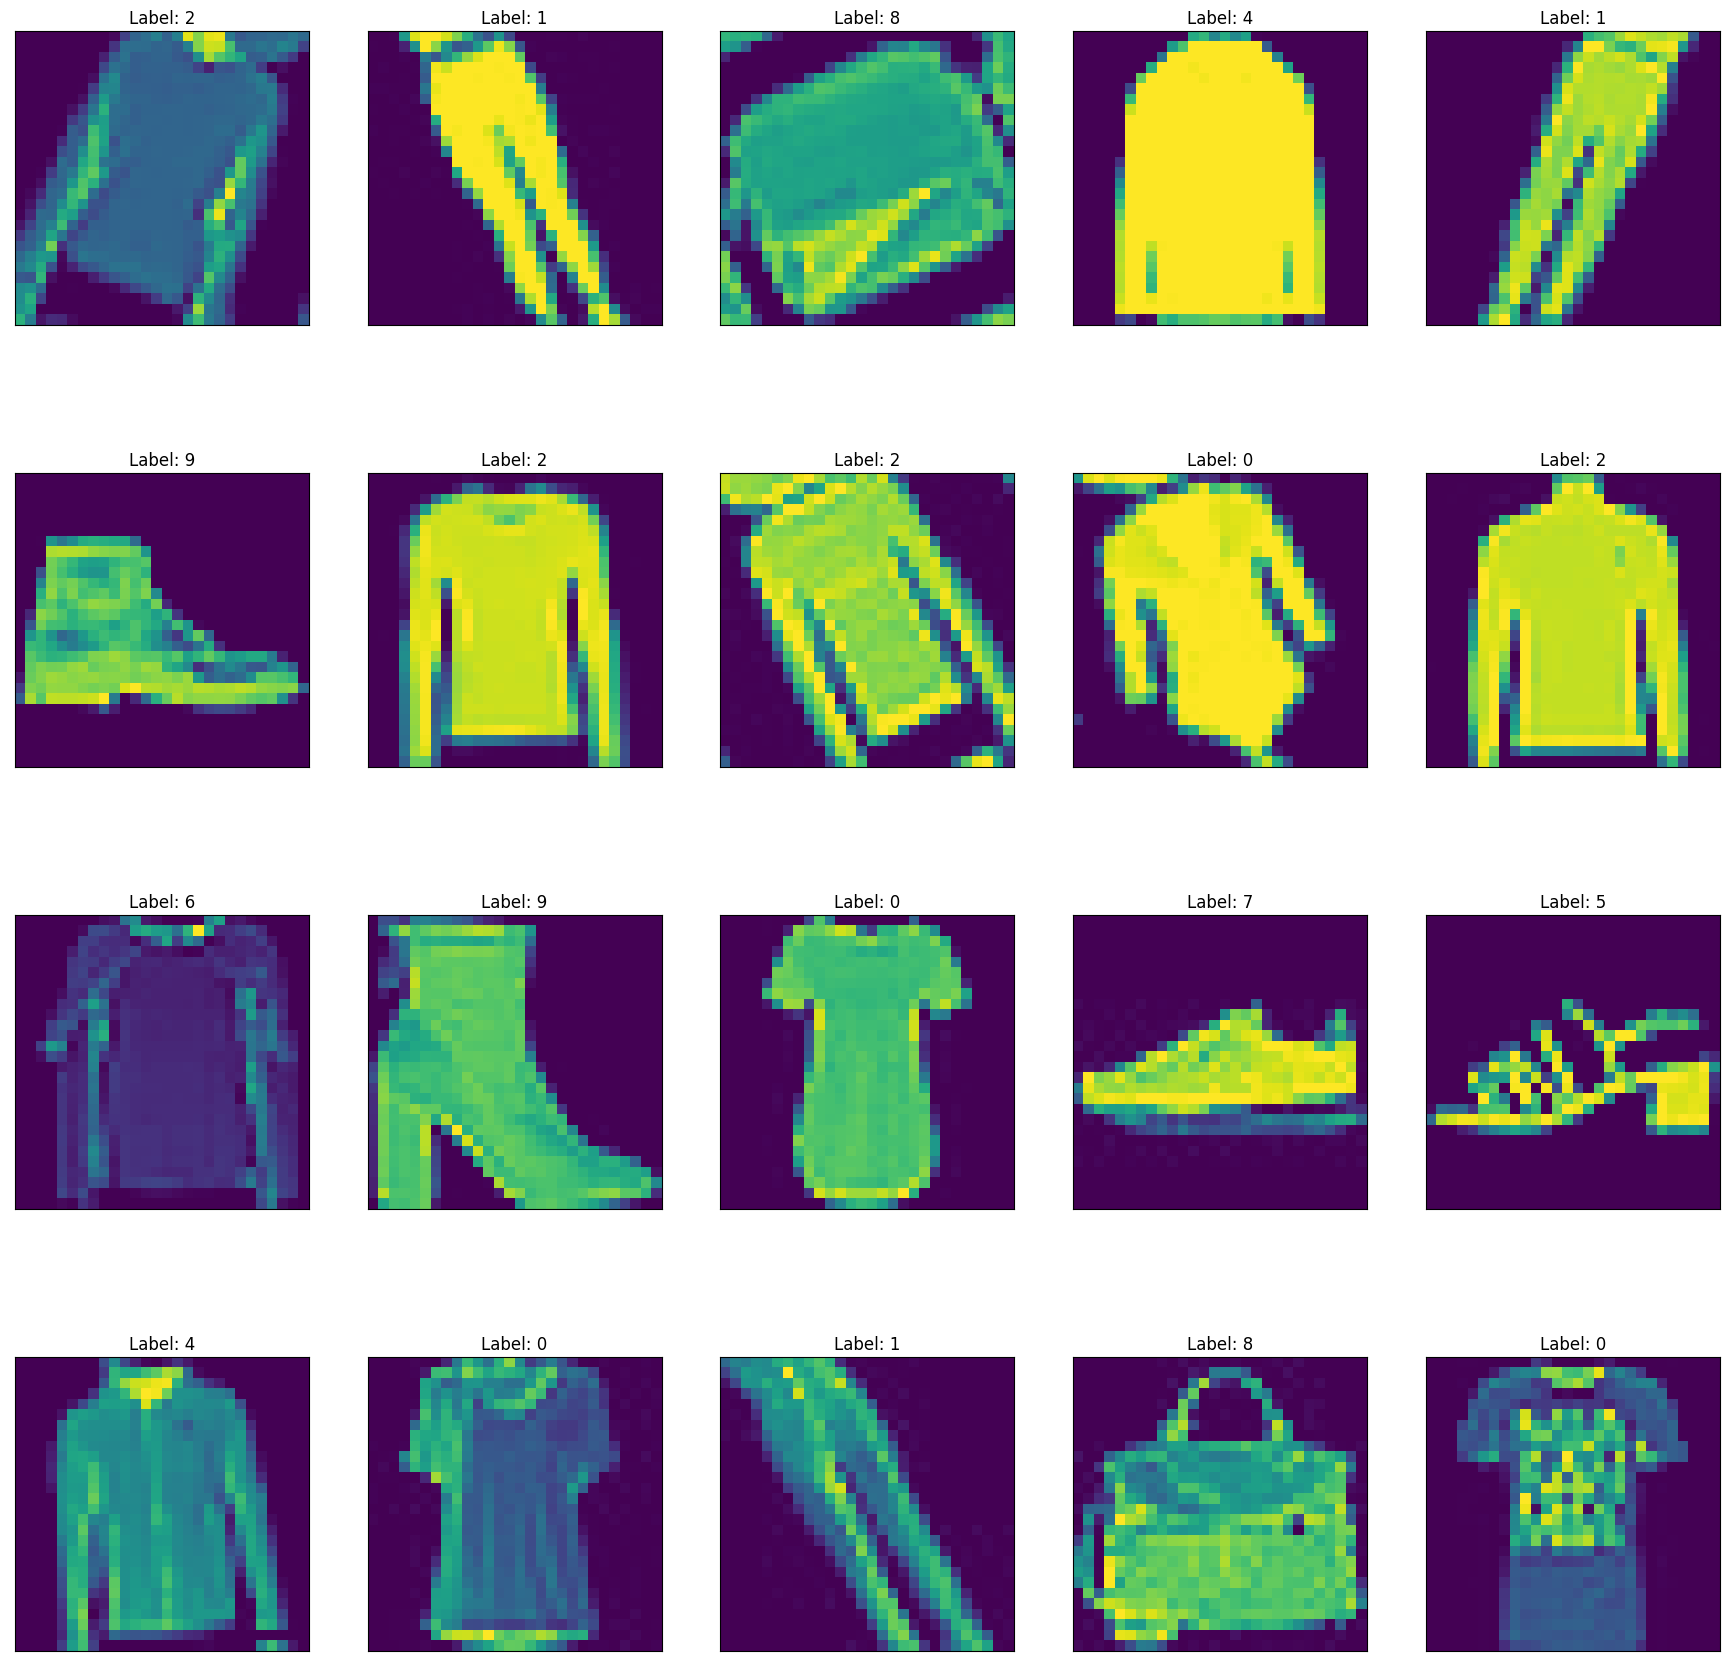

In [126]:
view_image(ds_alb)

### We can then pass in this dataset to out model and call fit on our model

In [149]:
new_model = create_model()
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_45 (Dense)            (None, 300)               235500    
                                                                 
 dense_46 (Dense)            (None, 200)               60200     
                                                                 
 dense_47 (Dense)            (None, 150)               30150     
                                                                 
 dense_48 (Dense)            (None, 100)               15100     
                                                                 
 dense_49 (Dense)            (None, 10)                1010      
                                                                 
Total params: 341,960
Trainable params: 341,960
Non-tr

In [148]:
new_model.fit(ds_alb, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.4263 - accuracy: 0.8426
Epoch 2/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.4158 - accuracy: 0.8443
Epoch 3/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.4050 - accuracy: 0.8501
Epoch 4/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.3981 - accuracy: 0.8526
Epoch 5/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.3859 - accuracy: 0.8575
Epoch 6/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.3798 - accuracy: 0.8583
Epoch 7/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.3758 - accuracy: 0.8601
Epoch 8/10
1875/1875 [==============================] - 78s 41ms/step - loss: 0.3669 - accuracy: 0.8634
Epoch 9/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.3642 - accuracy: 0.8641
Epoch 10/10
1875/1875 [==============================] - 72s 39m